# Using the LLaVa-NeXT-Video model for video-to-text tasks on Amazon SageMaker Asynchronous Endpoint with PyTorch DLC

❗This notebook works well with the `PyTorch 2.2.0 Python 3.10 CPU Optimized` kernel on a SageMaker Studio `ml.t3.medium` instance.

## Set up Environment

In [ ]:
%%capture --no-stderr

!pip install -U pip
!pip install -U "sagemaker>=2.221.1"

!pip install -U transformers==4.42.3

# we need av to be able to read the video
!pip install -U av==12.2.0

In [ ]:
!pip freeze | grep -E "av|sagemaker|torch|transformers"

In [ ]:
import boto3
import sagemaker


aws_region = boto3.Session().region_name
sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()

In [ ]:
import boto3
from typing import List


def get_cfn_outputs(stackname: str, region_name: str='us-east-1') -> List:
    cfn = boto3.client('cloudformation', region_name=region_name)
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

In [ ]:
CFN_STACK_NAME = "LlaVaNeXTVideoAsyncEndpointStack"
cfn_stack_outputs = get_cfn_outputs(CFN_STACK_NAME, aws_region)

endpoint_name = cfn_stack_outputs['EndpointName']
endpoint_name

## Create an Asynch Predictor with SageMaker Endpoint name

In [ ]:
from sagemaker import Predictor
from sagemaker.predictor_async import AsyncPredictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


serializer = JSONSerializer()
deserializer = JSONDeserializer()

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=serializer,
    deserializer=deserializer
)

async_predictor = AsyncPredictor(predictor=predictor)

## Download Sample Data

In [ ]:
%%sh

# copy the custom inference script into the working directory
cp -rp ../python/code ./

In [ ]:
import sys

sys.path.append('code')

from inference import read_video_from_url

In [ ]:
video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4'

clip_karate = read_video_from_url(video_url, sampling_rate=8)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_karate

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

## Run Inference by passing Video URL

In [ ]:
video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4'

prompt = 'USER: <video>\nWhat do you see in this video? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

video_data = {
    "inputs": video_url,
    "parameters": {
        "prompt": prompt,
        "generate_kwargs": generate_kwargs
    }
}

video_data

{'inputs': 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4',
 'parameters': {'prompt': 'USER: <video>\nWhat do you see in this video? ASSISTANT:',
  'generate_kwargs': {'max_new_tokens': 100, 'do_sample': True, 'top_p': 0.9}}}

In [ ]:
prefix = 'llava-hf-llava-next-video-7b-hf'
input_s3_path = f"s3://{bucket}/{prefix}/input/karate_video.json"

try:
    response = async_predictor.predict_async(
        data=video_data,
        input_path=input_s3_path
    )
except Exception as ex:
    import traceback
    traceback.print_exc()

In [ ]:
%%time
from sagemaker.async_inference.waiter_config import WaiterConfig

response.get_result(waiter_config=WaiterConfig(max_attempts=60, delay=15))

CPU times: user 69.5 ms, sys: 55.5 ms, total: 125 ms
Wall time: 1.11 s


['USER: \nWhat do you see in this video? ASSISTANT: This video shows a person in a martial arts outfit, likely engaged in a training session or preparing for a match. They are lying down on a floor with their head turned away from the camera, possibly performing exercises like shoulder shrugs, triceps dips, or some form of abdominal workout. The person appears to be focused on the exercises or warming up for the match ahead, with the lighting in the gym providing a g']

In [ ]:
!aws s3 ls {input_s3_path}

## Run Inference by passing Image URL

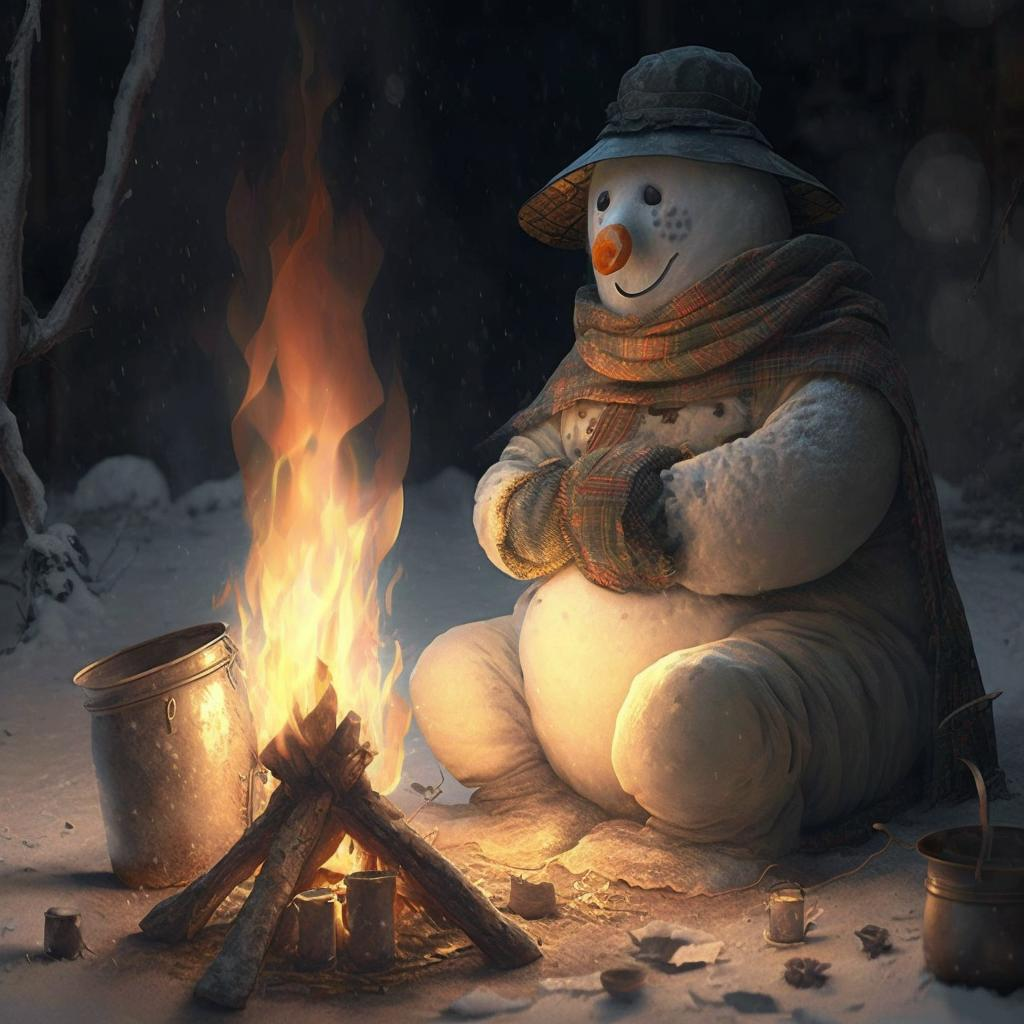

In [ ]:
import requests
from PIL import Image

image_snowman_url = 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg'
image_snowman = Image.open(requests.get(image_snowman_url, stream=True).raw)
image_snowman

In [ ]:
image_snowman_url = 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg'

prompt = 'USER: <image>\nWhat do you see in this image? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

image_data = {
    "inputs": image_snowman_url,
    "parameters": {
        "prompt": prompt,
        "generate_kwargs": generate_kwargs
    }
}

image_data

{'inputs': 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg',
 'parameters': {'prompt': 'USER: <image>\nWhat do you see in this image? ASSISTANT:',
  'generate_kwargs': {'max_new_tokens': 100, 'do_sample': True, 'top_p': 0.9}}}

In [ ]:
prefix = 'llava-hf-llava-next-video-7b-hf'
input_s3_path = f"s3://{bucket}/{prefix}/input/snowman_image.json"

try:
    response = async_predictor.predict_async(
        data=image_data,
        input_path=input_s3_path
    )
except Exception as ex:
    import traceback
    traceback.print_exc()

In [ ]:
%%time
from sagemaker.async_inference.waiter_config import WaiterConfig

response.get_result(waiter_config=WaiterConfig(max_attempts=60, delay=15))

CPU times: user 91.4 ms, sys: 2.07 ms, total: 93.5 ms
Wall time: 16.1 s


['USER: \nWhat do you see in this image? ASSISTANT: This image features a stylized snowman sitting at a makeshift fire in a snowy landscape. The snowman is wearing a hat, scarf, and a patterned scarf that has a warm tone with colors, indicating cold weather. Beside it, there are various items used for starting and maintaining the fire, such as a small candle, a metal pot or pan, a tealight, and a small container that appears to be a hot beverage.']

# Run Inference by passing base63 encoded Image

In [ ]:
import base64
from io import BytesIO

def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

In [ ]:
encoded_image = pil_image_to_base64(image_snowman)

prompt = 'USER: <image>\nWhat do you see in this image? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

encoded_image_data = {
    "inputs": encoded_image,
    "parameters": {
        "prompt": prompt,
        "generate_kwargs": generate_kwargs
    }
}

encoded_image_data

In [ ]:
prefix = 'llava-hf-llava-next-video-7b-hf'
input_s3_path = f"s3://{bucket}/{prefix}/input/snowman_encoded_image.json"

try:
    response = async_predictor.predict_async(
        data=encoded_image_data,
        input_path=input_s3_path
    )
except Exception as ex:
    import traceback
    traceback.print_exc()

In [ ]:
%%time
from sagemaker.async_inference.waiter_config import WaiterConfig

response.get_result(waiter_config=WaiterConfig(max_attempts=60, delay=15))

CPU times: user 87.5 ms, sys: 4.34 ms, total: 91.8 ms
Wall time: 16.1 s


["USER: \nWhat do you see in this image? ASSISTANT: The image shows a snowman sitting by a campfire in a snowy landscape. The snowman has a beanie on its head and is dressed in winter clothing. Beside the fire, there is a bucket, presumably for cooking or holding firewood, and a mug. The fire appears to be burning brightly, casting a warm glow on the surrounding area. In the background, there's a frosty, snowy landscape that gives the impression of a winter"]

## References

- [LLaVa-NeXT-Video Model Card](https://huggingface.co/llava-hf/LLaVA-NeXT-Video-7B-hf)
- [HuggingFace Transformers Supported models and frameworks](https://huggingface.co/docs/transformers/index#supported-models-and-frameworks)